In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

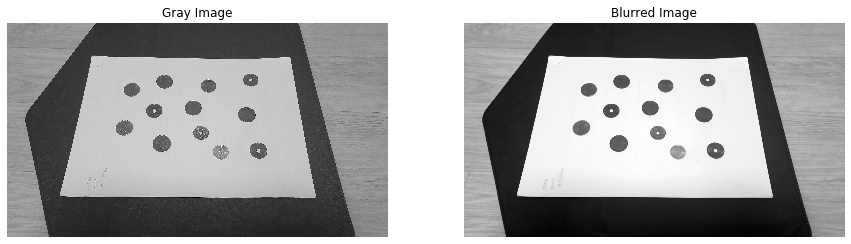

In [2]:
img = cv2.imread('./images/coin9.jpg')
img_ori = img.copy()
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Blurring

dst = cv2.bilateralFilter(img_gray, 10, 100, 100) # Bilateral Filtering
dst1 = cv2.GaussianBlur(dst, (5,5), 0)       # GaussianBlur
dst2 = cv2.medianBlur(dst1, 9)                # Median Blur


plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_gray, cmap='gray'), plt.title('Gray Image'), plt.axis('off')
plt.subplot(122), plt.imshow(dst2, cmap='gray'), plt.title('Blurred Image'), plt.axis('off')
plt.show()

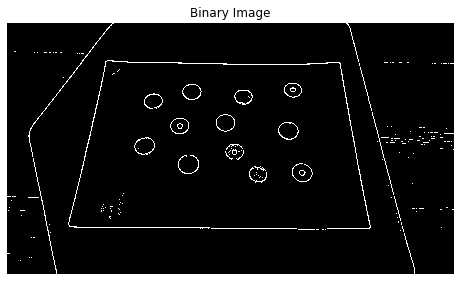

In [3]:
binary_img = cv2.adaptiveThreshold(dst2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 33, 5)
#binary_img = cv2.threshold(dst2, 170, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(8,8))
plt.imshow(binary_img, cmap='gray'), plt.title('Binary Image'), plt.axis('off')
plt.show()

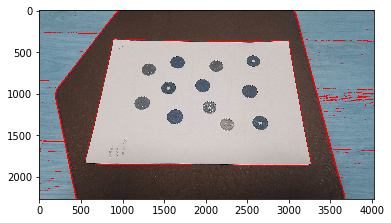

In [4]:
img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

img = img_ori.copy()

# Draw Contour with Blue
cv2.drawContours(img, contour, -1, (255,0,0), 5)
plt.figure()
plt.imshow(img)

In [5]:
#print(len(contour[0]))
#print(len(contour[1]))
max = 0;
index = -1;
for i in range(len(contour)):
   # print(max,i)
    if(max<len(contour[i])):        
        index = i
        max = len(contour[i])
        print(max, i)

7 0
33 5
36 89
110 106
116 120
2008 360
2454 402


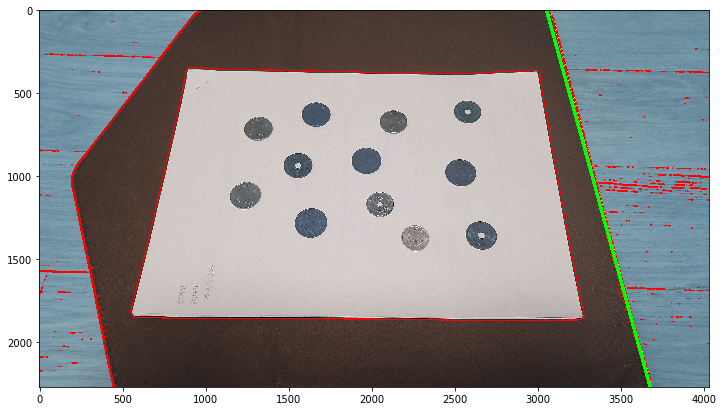

In [6]:
cnt = contour[index]
cv2.drawContours(img, [cnt], 0, (255, 255, 0), 1)

epsilon1 = 0.1*cv2.arcLength(cnt, True)
approx1 = cv2.approxPolyDP(cnt, epsilon1, True)
cv2.drawContours(img, [approx1], 0, (0, 255, 0), 20)

plt.figure(figsize=(12,12))
plt.imshow(img)

1550 0


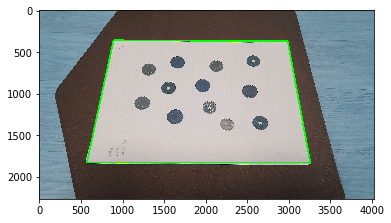

In [7]:
#만약 정상적으로 4개의 점을 찾지 못하면 threshold를 이용하여 재시도
if (len(approx1)!=4):
    ret_threshold, binary_img = cv2.threshold(dst2,
                                          170,
                                          255,
                                          cv2.THRESH_BINARY)
    
    img, contour, hierarchy = cv2.findContours(binary_img, 
                                            cv2.RETR_EXTERNAL, 
                                            cv2.CHAIN_APPROX_SIMPLE)

    img = img_ori.copy()   
    
    max = 0;
    index = -1;
    for i in range(len(contour)):
   # print(max,i)         if(max<len(contour[i])):        
            index = i
            max = len(contour[i])
            print(max, i)
            cnt=contour[index]

    cv2.drawContours(img, [cnt], 0, (255, 255, 0), 1)

    epsilon1 = 0.1*cv2.arcLength(cnt, True)
    approx1 = cv2.approxPolyDP(cnt, epsilon1, True)
    
    cv2.drawContours(img, [approx1], 0, (0, 255, 0), 20)
    plt.imshow(img)

else:
    pass

In [8]:
print(approx1)

approx_list = []
for i in range(8):
    vals = approx1.item(i)
    approx_list.append(vals)
    
approx_list = np.array(approx_list)
pts1 = approx_list.reshape(4,-1).astype(np.float32)

[[[ 897  364]]

 [[ 576 1831]]

 [[3264 1829]]

 [[2993  372]]]


In [9]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

2096.0152671199703
1481.9885289704505


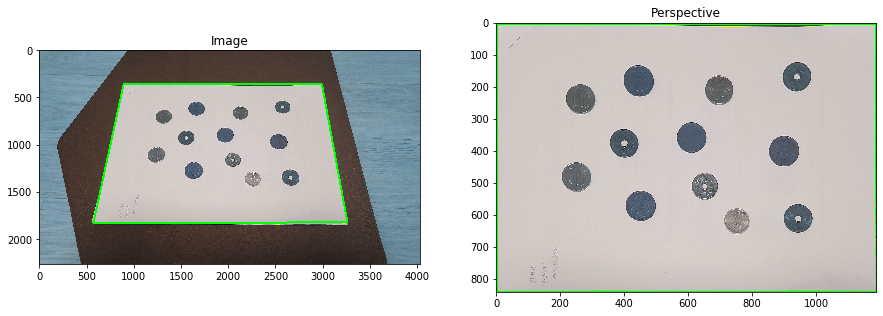

True

In [10]:
pts1 = order_points(pts1)

def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

dist0_1 = distance(pts1[0], pts1[1])
dist1_2 = distance(pts1[1], pts1[2])
print(dist0_1)
print(dist1_2)


if(dist0_1 > dist1_2):
    pts2 = np.float32([[0,0],[1189,0],[1189,841],[0,841]]) # 이 상태는 좌측하단, 우측상단, 우측하단, 좌측상단임
elif(dist0_1 < dist1_2):
    pts2 = np.float32([[1189,0],[1189,841],[0,841], [0,0]]) # 이 상태는 좌측상단, 우측상단, 우측하단, 좌측하단임  


M = cv2.getPerspectiveTransform(pts1, pts2)
dst = cv2.warpPerspective(img, M, (1189, 841))    
 
    
    
cv2.imshow('img',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img),plt.title('Image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()

cv2.imwrite('done.jpg', dst)

In [11]:
#원의 윤곽 부각되도록
image = dst
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
line = cv2.bilateralFilter(blur, 5, 30, 30) # Bilateral Filtering
cv2.imwrite('done.jpg', line)

True

In [12]:
overlap = cv2.imread('done.jpg', 0)            # Blur 처리해서 noise를 제거한다
cimg = cv2.cvtColor(overlap, cv2.COLOR_GRAY2BGR)


# 겹친 동전의 모양까지 원으로 검출하는 기준을 정의한다
circles = cv2.HoughCircles(overlap, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), param1=150, param2=20, minRadius=15, maxRadius=50)
circles = np.uint16(circles)

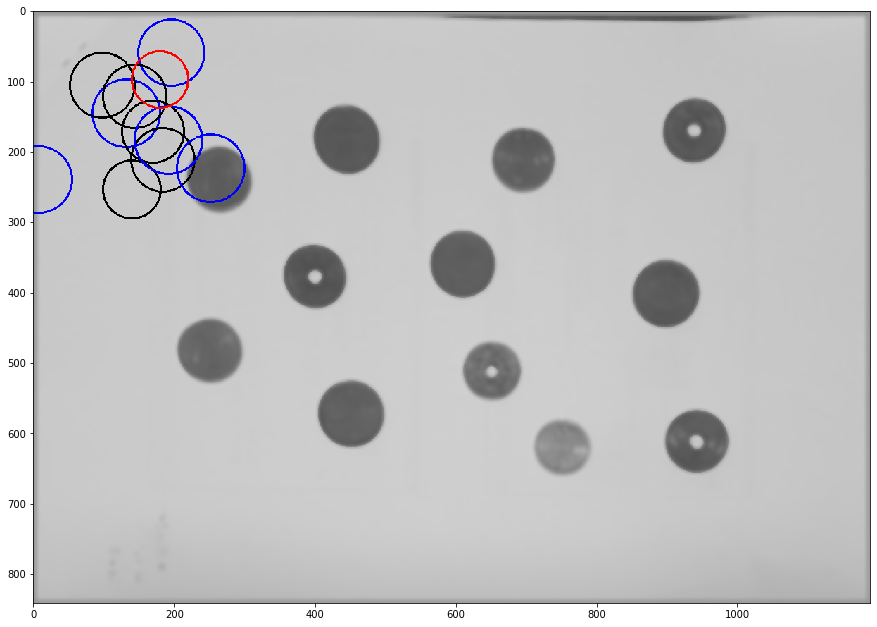

In [14]:
overlap = cv2.imread('done.jpg', 0)              # 위에서까지 실행한 이미지를 'done.jpg'라고 저장하고, overlap에 불러옴
overlap = cv2.bilateralFilter(overlap, 10, 100, 100) # Bilateral Filtering
cimg = cv2.cvtColor(overlap, cv2.COLOR_GRAY2BGR)


# 겹친 동전의 모양까지 원으로 검출하는 기준을 정의한다
circles = cv2.HoughCircles(overlap, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), param1=150, param2=20, minRadius=0, maxRadius=55)
circles = np.uint8(np.around(circles))

count500 = 0
count100 = 0
count50 = 0
count10 = 0
count5 = 0
count1 = 0


# 위 조건에 맞춰 cimg에 원을 그린다
for circ in circles[0,:]:
    if circ[2] >= 50:
        count500 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,255,0) ,2)
    elif circ[2] >= 47:
        count100 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,255) ,2)
    elif circ[2] >= 45:
        count50 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,0) ,2)
    elif circ[2] >= 44:
        count10 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,0) ,2)
    elif circ[2] >= 41:
        count5 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (0,0,0) ,2)        
    else:
        count1 += 1
        cv2.circle(cimg, (circ[0], circ[1]), circ[2], (255,0,0), 2)


# 원형의 컨투어가 따인 cimg 출력
cv2.imshow('img', cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(15,15))
plt.imshow(cimg)
plt.show()

In [15]:
# 동전 좌표 확인하기

count = circles[0,:]        # 인식된 원의 개수를 count라고 지정한다
# len(count)
c_array = circles.reshape(len(count), -1)                      # 검출된 원의 개수를 행의 개수로 하는 배열을 array라고 지정한다
radiusSet = c_array[:,-1]

print('\n(x좌표, y좌표, 반지름) 배열: \n', c_array)     # 여기서 x,y좌표는 원의 중심의 좌표를 의미함
print('\n동전의 반지름 리스트: \n', radiusSet)


(x좌표, y좌표, 반지름) 배열: 
 [[196  60  47]
 [132 146  48]
 [184 212  45]
 [144 122  45]
 [140 254  41]
 [170 172  44]
 [ 98 106  46]
 [192 184  48]
 [  8 240  47]
 [252 224  48]
 [180  98  40]]

동전의 반지름 리스트: 
 [47 48 45 45 41 44 46 48 47 48 40]


In [16]:
# 총액 계산하기

total = (500 * fivehund + 100 * onehund + 50 * fifty + 10 * ten)

print('500원: {} 개'.format(fivehund),
      '\n100원: {} 개'.format(onehund),
      '\n 50원: {} 개'.format(fifty),
      '\n 10원: {} 개'.format(ten))
print('동전 총합: {} 원'.format(total))

NameError: name 'fivehund' is not defined

In [ ]:
import requests
import json
import math

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

def jpy2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWJPY'
    exchange =requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']

def usd2krw():
    url = 'https://quotation-api-cdn.dunamu.com/v1/forex/recent?codes=FRX.KRWUSD'
    exchange =requests.get(url, headers=headers).json()
    return exchange[0]['basePrice']


# 외화 1 단위 --> 원화
usd = usd2krw()
jpy = jpy2krw()

print('환율 : 1$ 당', usd)
print('환율 : 1¥ 당', jpy / 100)


# 원화 --> 외화
usd_tot = total / usd
usd_tot = math.floor(usd_tot)

jpy_tot = total / (jpy/100)
jpy_tot = math.floor(jpy_tot)

print('\n총 {}$입니다.'.format(usd_tot))
print('총 {}¥입니다'.format(jpy_tot))